# Baseline model using Linear Regression

## Imports

In [1]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import root_mean_squared_error
from sklearn import set_config

from utils import PROCESSED_DATA_DIR, VALIDATION_CUTOFF, print_metrics

pl.Config.set_tbl_rows(20)
set_config(transform_output = "pandas")

## Data loading

In [2]:
processed_train_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('training', 'train_full.parquet')
)

processed_train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [3]:
processed_train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1698818""",1.698818e6,"""1698818""","""1698818""",1.698818e6,1.698818e6,1.698818e6,1.698818e6,"""1599704""","""1599704""",1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.598505e6,1.598505e6,1.698818e6,1.698818e6,1.698818e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""99114""","""99114""",99114.0,99114.0,99114.0,99114.0,99114.0,99114.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5910.75087,"""2018-06-24""","""2018-06-07""",710.461822,17.419005,0.695564,5.91818,"""2018-07-01 06:49:28.030135""","""2018-07-01 08:45:02.581152""",115.57585,-405.751189,0.013588,2.93231,23.034132,5.301361,5721.521024,271.993762,3.944983,3.839782,0.058343
"""std""",null,4285.440264,null,null,543.207638,12.959215,0.460168,2.968049,null,null,62.670552,62.255521,0.115774,1.260417,11.898872,2.971523,2358.75767,63.198466,1.690606,1.631242,0.234391
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-30""","""2018-03-12""",395.0,8.0,0.0,4.0,"""2018-04-04 08:05:00""","""2018-04-04 10:37:00""",78.0,-420.0,0.0,2.0,9.0,3.0,2864.0,223.0,3.0,3.0,0.0
"""50%""",null,5280.0,"""2018-06-08""","""2018-05-22""",552.0,16.0,1.0,6.0,"""2018-06-20 06:05:00""","""2018-06-20 07:57:00""",89.0,-420.0,0.0,3.0,22.0,5.0,7022.0,270.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-09-24""","""2018-09-06""",825.0,26.0,1.0,8.0,"""2018-09-29 10:40:00""","""2018-09-29 12:28:00""",106.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-12-31""","""2018-12-31""",7859.0,328.0,1.0,11.0,"""2018-12-31 22:52:00""","""2019-01-01 00:26:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


In [4]:
train_df = processed_train_df.filter(
    pl.col('flt_departure_dt') <= VALIDATION_CUTOFF
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [5]:
train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1556671""",1.556671e6,"""1556671""","""1556671""",1.556671e6,1.556671e6,1.556671e6,1.556671e6,"""1460289""","""1460289""",1.460289e6,1.460289e6,1.460289e6,1.460289e6,1.460289e6,1.460289e6,1.456358e6,1.456358e6,1.556671e6,1.556671e6,1.556671e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""96382""","""96382""",96382.0,96382.0,96382.0,96382.0,96382.0,96382.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5911.454399,"""2018-06-08""","""2018-05-22""",698.183723,17.265929,0.759079,5.935386,"""2018-06-15 04:15:06.345305""","""2018-06-15 06:10:36.537699""",115.503207,-401.853921,0.013829,2.936193,23.187674,5.327998,5772.255902,272.205624,3.954633,3.838421,0.061915
"""std""",null,4283.113936,null,null,466.055604,12.725705,0.427643,2.968212,null,null,62.531057,61.484587,0.116783,1.262305,11.932692,2.9922,2377.101806,63.219415,1.691103,1.626951,0.241002
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-26""","""2018-03-09""",395.0,8.0,1.0,4.0,"""2018-03-30 18:40:00""","""2018-03-30 20:37:00""",79.0,-420.0,0.0,2.0,9.0,3.0,2864.0,222.0,3.0,3.0,0.0
"""50%""",null,5274.0,"""2018-05-20""","""2018-05-04""",552.0,16.0,1.0,6.0,"""2018-06-01 22:56:00""","""2018-06-02 00:11:00""",89.0,-420.0,0.0,3.0,23.0,5.0,7054.0,273.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-08-28""","""2018-08-11""",819.0,26.0,1.0,8.0,"""2018-09-03 20:52:00""","""2018-09-03 22:38:00""",105.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-11-30""","""2018-11-30""",6354.0,328.0,1.0,11.0,"""2018-11-30 22:45:00""","""2018-12-01 00:02:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


In [6]:
val_df = processed_train_df.filter(
    (pl.col('flt_departure_dt') > VALIDATION_CUTOFF) & 
    (
        pl.col('flt_departure_dt') <= (VALIDATION_CUTOFF + pl.duration(days = 7))
    )
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72,-480,0,2,32,9,7128,224,4,3,0
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84,-480,0,2,32,9,7128,224,4,3,0
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72,-480,0,3,32,9,7128,224,4,3,0
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72,-480,0,4,32,10,7128,224,4,3,0
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77,-480,1,5,32,1,7128,224,4,3,0
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72,-480,0,3,32,9,7128,224,4,3,0
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72,-480,0,4,32,10,7128,224,4,3,0
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187,-300,0,5,4,1,2164,373,1,5,0
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197,-300,0,3,4,1,2164,373,1,5,0


In [7]:
val_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""29492""",29492.0,"""29492""","""29492""",29492.0,29492.0,29492.0,29492.0,"""29462""","""29462""",29462.0,29462.0,29462.0,29462.0,29462.0,29462.0,29492.0,29492.0,29492.0,29492.0,29492.0
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""30""","""30""",30.0,30.0,30.0,30.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,5931.477418,"""2018-12-04""","""2018-11-16""",636.639767,17.878611,0.0,5.770005,"""2018-12-04 15:19:48.756364""","""2018-12-04 17:13:48.900956""",114.00241,-447.238477,0.00818,2.917792,22.015613,5.295771,5224.45097,268.025397,3.864946,3.839278,0.001017
"""std""",null,4253.523118,null,null,426.948517,14.627672,0.0,2.947329,null,null,63.011074,54.955176,0.090074,1.230295,12.075227,2.892415,2099.212104,62.301247,1.66831,1.65516,0.031878
"""min""","""L1""",752.0,"""2018-12-01""","""2018-03-04""",263.0,0.0,0.0,0.0,"""2018-12-01 00:40:00""","""2018-12-01 05:34:00""",61.0,-480.0,0.0,0.0,4.0,1.0,1618.0,165.0,0.0,0.0,0.0
"""25%""",null,2667.0,"""2018-12-02""","""2018-11-08""",360.0,8.0,0.0,4.0,"""2018-12-02 19:35:00""","""2018-12-02 21:05:00""",77.0,-480.0,0.0,2.0,8.0,3.0,2790.0,227.0,3.0,3.0,0.0
"""50%""",null,5663.0,"""2018-12-04""","""2018-11-18""",505.0,16.0,0.0,5.0,"""2018-12-04 15:10:00""","""2018-12-04 17:06:00""",85.0,-480.0,0.0,3.0,21.0,5.0,5817.0,253.0,3.0,3.0,0.0
"""75%""",null,7019.0,"""2018-12-06""","""2018-11-26""",724.0,26.0,0.0,7.0,"""2018-12-06 11:05:00""","""2018-12-06 12:38:00""",107.0,-420.0,0.0,4.0,35.0,8.0,7128.0,294.0,5.0,5.0,0.0
"""max""","""U3""",18769.0,"""2018-12-07""","""2018-12-07""",7859.0,276.0,0.0,11.0,"""2018-12-07 22:45:00""","""2018-12-08 00:02:00""",301.0,-300.0,1.0,5.0,37.0,11.0,7128.0,405.0,7.0,7.0,1.0


## Data processing

### Fare rescaling

#### Check if any (`route`, `carrier`) pair is missing in `train_df`

In [8]:
train_df.group_by('route_id', 'carrier').len().drop('len').join(
    val_df.group_by('route_id', 'carrier').len().drop('len'),
    on = ['route_id', 'carrier'],
    how = 'outer'
).null_count()

route_id,carrier,route_id_right,carrier_right
u32,u32,u32,u32
0,0,4,4


#### Calculating range of log of fares by (`route`, `carrier`)

In [9]:
train_df.group_by('route_id', 'carrier').agg(
    (pl.col('total_fare').max() / pl.col('total_fare').mean()).alias('up_range'),
    (pl.col('total_fare').min() / pl.col('total_fare').mean()).alias('down_range')
).describe()

statistic,route_id,carrier,up_range,down_range
str,f64,str,f64,f64
"""count""",34.0,"""34""",34.0,34.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",5.588235,null,4.523691,0.462604
"""std""",3.239132,null,1.945465,0.081088
"""min""",0.0,"""L1""",2.05318,0.278275
"""25%""",3.0,null,2.838609,0.415042
"""50%""",5.0,null,4.284137,0.46635
"""75%""",8.0,null,5.292899,0.521188
"""max""",11.0,"""U3""",9.486336,0.623127


In [10]:
base_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').log10().mean().alias('base_fare'),
    pl.col('total_fare').log10().std().alias('std_fare'),
    pl.col('total_fare').log10().min().alias('min_fare'),
    pl.col('total_fare').log10().max().alias('max_fare')
).sort('route_id', 'carrier')

base_fares

route_id,carrier,base_fare,std_fare,min_fare,max_fare
u8,str,f64,f64,f64,f64
0,"""L1""",2.877514,0.194479,2.472756,3.764923
0,"""U3""",2.728148,0.140458,2.468347,3.099681
1,"""L1""",2.991069,0.197935,2.638489,3.749659
2,"""L1""",2.931838,0.205985,2.472756,3.725503
2,"""OTH""",2.758927,0.160084,2.448706,3.170555
2,"""U3""",2.701619,0.194855,2.418301,3.237795
3,"""L1""",2.972533,0.216676,2.472756,3.730621
3,"""OTH""",2.763481,0.173673,2.448706,3.170555
3,"""U3""",2.808008,0.214577,2.418301,3.169674


In [11]:
base_fares.select(pl.col(pl.Float64())).describe()

statistic,base_fare,std_fare,min_fare,max_fare
str,f64,f64,f64,f64
"""count""",34.0,34.0,34.0,34.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2.780166,0.182301,2.481561,3.440914
"""std""",0.131822,0.029635,0.088668,0.251219
"""min""",2.578117,0.11764,2.369216,3.05423
"""25%""",2.671029,0.161205,2.418301,3.24005
"""50%""",2.763481,0.182345,2.472756,3.438226
"""75%""",2.877514,0.20389,2.489958,3.672283
"""max""",3.021101,0.24627,2.669317,3.803047


In [12]:
train_df = train_df.join(
    base_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

train_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",1.556671e6
"""null_count""",0.0
"""mean""",-0.000001
"""std""",0.068808
"""min""",-0.1681
"""25%""",-0.0505
"""50%""",-0.013
"""75%""",0.0407
"""max""",0.3802


In [13]:
val_df = val_df.join(
    base_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

val_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",29492.0
"""null_count""",0.0
"""mean""",-0.017314
"""std""",0.070193
"""min""",-0.1681
"""25%""",-0.0707
"""50%""",-0.0312
"""75%""",0.0229
"""max""",0.5109


In [14]:
train_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",6523,2018-03-06,2018-02-26,297,8,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-03-06,2018-02-27,297,7,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",5663,2018-03-09,2018-02-25,297,12,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",5663,2018-03-09,2018-02-26,297,11,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",3861,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 15:55:00,2018-03-10 20:52:00,297,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",5663,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 12:17:00,2018-03-10 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6294,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 13:45:00,2018-03-10 18:43:00,298,-480,0,3,8,3,2873,392,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-03-10,2018-02-24,297,14,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.972533,2.472756,-0.1681


In [15]:
val_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",2149,2018-12-04,2018-11-13,297,21,0,3,2018-12-04 01:05:00,2018-12-04 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-10-24,297,42,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-10-27,297,39,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-10-31,297,35,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-01,297,34,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-02,297,33,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-04,297,31,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",6523,2018-12-05,2018-11-12,297,23,0,3,2018-12-05 06:00:00,2018-12-05 10:51:00,291,-480,0,1,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681
"""L1""",2149,2018-12-05,2018-11-13,297,22,0,3,2018-12-05 01:05:00,2018-12-05 05:59:00,294,-480,0,0,8,1,2790,405,3,2,0,2.972533,2.472756,-0.1681


#### Metrics when predicting `base_fare`

In [16]:
print_metrics(
    train_df['total_fare'], 
    train_df.select(pl.lit(10).pow('base_fare').alias('pred_fare'))['pred_fare'],
    label = 'Train - Mean Baseline'
)

print_metrics(
    val_df['total_fare'], 
    val_df.select(pl.lit(10).pow('base_fare').alias('pred_fare'))['pred_fare'],
    label = 'Val - Mean Baseline'
)

Train - Mean Baseline
RMSE: 420.4827
MAE: 257.1919
R2: 18.601%
Max error: 5625.3791

Val - Mean Baseline
RMSE: 393.2156
MAE: 266.0133
R2: 15.175%
Max error: 7480.4558



### Feature generation

#### Days since start

In [17]:
train_df = train_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.755964,2.671173,-0.0308,0
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.991069,3.04883,0.0193,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.733692,2.625312,-0.0396,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589739,2.895975,0.1182,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.763495,3.113275,0.1266,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.766269,2.570543,-0.0708,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.638819,2.710117,0.027,0
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578117,2.635484,0.0223,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,0


In [18]:
val_df = val_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.454845,-0.0774,334
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77,-480,1,5,32,1,7128,224,4,3,0,2.660753,2.454845,-0.0774,334
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.596597,-0.0241,334
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187,-300,0,5,4,1,2164,373,1,5,0,2.991069,2.724276,-0.0892,334
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197,-300,0,3,4,1,2164,373,1,5,0,2.991069,2.90309,-0.0294,334


#### Flight date features

In [19]:
train_df = train_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.755964,2.671173,-0.0308,0,1,1,1,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.991069,3.04883,0.0193,0,1,1,1,1
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.733692,2.625312,-0.0396,0,1,1,1,1
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589739,2.895975,0.1182,0,1,1,1,1
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.763495,3.113275,0.1266,0,1,1,1,1
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.766269,2.570543,-0.0708,0,1,1,1,1
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.638819,2.710117,0.027,0,1,1,1,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578117,2.635484,0.0223,0,1,1,1,1
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,0,1,1,1,1


In [20]:
val_df = val_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.454845,-0.0774,334,12,1,48,6
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77,-480,1,5,32,1,7128,224,4,3,0,2.660753,2.454845,-0.0774,334,12,1,48,6
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.596597,-0.0241,334,12,1,48,6
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187,-300,0,5,4,1,2164,373,1,5,0,2.991069,2.724276,-0.0892,334,12,1,48,6
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197,-300,0,3,4,1,2164,373,1,5,0,2.991069,2.90309,-0.0294,334,12,1,48,6


### Imputation

#### Null counts

In [21]:
train_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,96382,96382,96382,96382,96382,96382,96382,96382,100313,100313,0,0,0,0,0,0,0,0,0,0,0


In [22]:
val_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Flight duration

In [23]:
mean_durations = train_df.group_by('route_id', 'carrier').agg(
    pl.col('dur_min').mean().round(2).alias("dur_mean"),
    pl.col('dur_min').std().round(2).alias("dur_std")
).sort('route_id', 'carrier')

mean_durations

route_id,carrier,dur_mean,dur_std
u8,str,f64,f64
0,"""L1""",190.82,5.32
0,"""U3""",193.89,3.55
1,"""L1""",187.99,14.32
2,"""L1""",77.39,7.55
2,"""OTH""",73.2,7.75
2,"""U3""",94.24,1.8
3,"""L1""",296.7,3.88
3,"""OTH""",297.0,3.37
3,"""U3""",301.47,1.35


In [24]:
train_df = train_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

train_df['dur_min'].null_count()

0

In [25]:
val_df = val_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

val_df['dur_min'].null_count()

0

### Training datasets

In [26]:
TRAINING_COLS = [
    'carrier', 'days_till_flight', 'origin_id', 'destination_id', 
    'dur_min', 'flt_info_null', 'days_since_start', 'is_dst',
    'flt_departure_month', 'flt_departure_day',
    'flt_departure_week', 'flt_departure_weekday'
]

X_train = train_df.select(TRAINING_COLS)
X_val = val_df.select(TRAINING_COLS)

y_train = train_df['scaled_fare']
y_val = val_df['scaled_fare']

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1556671, 12), (29492, 12), (1556671,), (29492,))

## Modelling

### Training

In [27]:
pred_fare_expr = pl.lit(10).pow(
    (pl.col('pred_scaled_fare') * pl.col('base_fare')) + pl.col('base_fare')
).alias('pred_fare')

def get_model():
    col_transform = ColumnTransformer(
        [
            (
                'scaler', 
                StandardScaler(),
                [
                    'days_till_flight', 'dur_min', 'days_since_start', 
                    'flt_departure_month', 'flt_departure_day',
                    'flt_departure_week', 'flt_departure_weekday'
                ]
            ),
            (
                'ohe', 
                OneHotEncoder(drop = 'first', sparse_output = False),
                ['carrier', 'origin_id', 'destination_id']
            )
        ],
        remainder = 'passthrough',
        sparse_threshold = 0
    )

    return Pipeline(
        [
            ('col_transformer', col_transform),
            ('ridge', Ridge())
        ]
    )

def train_model(param_grid, n_iter = 5):
    param_sampler = ParameterSampler(
        param_grid,
        n_iter = n_iter,
        random_state = 7
    )

    best_rmse = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(list(param_sampler)):
        model = get_model()
        model.set_params(**params)
        model.fit(X_train, y_train)

        val_preds = val_df.with_columns(
            pred_scaled_fare = model.predict(X_val)
        ).with_columns(pred_fare_expr)['pred_fare']

        rmse = root_mean_squared_error(val_df['total_fare'], val_preds)
        print(f"{i} : {rmse:.3f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print(f"Best params:\n{best_params}")
    return best_model

param_grid = {
    "ridge__alpha": [1_000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001]
}

best_model = train_model(param_grid)
best_model

0 : 355.678
1 : 355.899
2 : 355.550
3 : 355.899
4 : 355.870
Best params:
{'ridge__alpha': 1000.0}


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('scaler', StandardScaler(),
                                                  ['days_till_flight',
                                                   'dur_min',
                                                   'days_since_start',
                                                   'flt_departure_month',
                                                   'flt_departure_day',
                                                   'flt_departure_week',
                                                   'flt_departure_weekday']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['carrier', 'origin_id',
                                                   'destination_id'])])),
                ('ridge', Ridge(alpha=1000.0))])

### Predictions

In [28]:
train_df = train_df.with_columns(
    pred_scaled_fare = best_model.predict(X_train)
).with_columns(pred_fare_expr)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,94.43,null,null,null,null,null,null,null,7,3,1,2.755964,2.671173,-0.0308,0,1,1,1,1,94.43,-0.059905,389.824522
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197.0,-300,0,5,5,1,1468,360,1,5,0,2.991069,3.04883,0.0193,0,1,1,1,1,187.99,-0.058104,656.562079
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75.0,-480,0,3,30,9,6659,228,4,3,0,2.733692,2.625312,-0.0396,0,1,1,1,1,78.38,-0.059891,371.508153
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84.0,-480,0,5,30,4,6659,316,3,4,0,2.589739,2.895975,0.1182,0,1,1,1,1,81.52,-0.056915,276.91409
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83.0,-480,0,2,30,5,6659,231,3,4,0,2.763495,3.113275,0.1266,0,1,1,1,1,79.11,-0.059553,397.117433
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93.0,-480,0,4,21,7,6579,262,7,3,0,2.766269,2.570543,-0.0708,0,1,1,1,1,95.27,-0.0599,398.629356
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,80.14,null,null,null,null,null,null,null,3,4,1,2.638819,2.710117,0.027,0,1,1,1,1,80.14,-0.060464,301.484326
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72.0,-480,0,3,30,9,6659,316,4,3,0,2.578117,2.635484,0.0223,0,1,1,1,1,71.32,-0.058225,267.919923
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88.0,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,0,1,1,1,1,90.69,-0.058859,370.780635


In [29]:
val_df = val_df.with_columns(
    pred_scaled_fare = best_model.predict(X_val)
).with_columns(pred_fare_expr)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""L2""",7220,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 10:15:00,2018-12-01 11:27:00,72.0,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6,78.3,-0.060901,315.290859
"""L2""",4448,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 08:40:00,2018-12-01 10:04:00,84.0,-480,0,2,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6,78.3,-0.057981,320.982281
"""L2""",7402,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 14:10:00,2018-12-01 15:22:00,72.0,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6,78.3,-0.060901,315.290859
"""L2""",2200,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 19:50:00,2018-12-01 21:02:00,72.0,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.454845,-0.0774,334,12,1,48,6,78.3,-0.060901,315.290859
"""L2""",8903,2018-12-01,2018-10-02,285,60,0,6,2018-12-01 22:45:00,2018-12-02 00:02:00,77.0,-480,1,5,32,1,7128,224,4,3,0,2.660753,2.454845,-0.0774,334,12,1,48,6,78.3,-0.059684,317.649917
"""L2""",5041,2018-12-01,2018-10-02,476,60,0,6,2018-12-01 12:40:00,2018-12-01 13:52:00,72.0,-480,0,3,32,9,7128,224,4,3,0,2.660753,2.677607,0.0063,334,12,1,48,6,78.3,-0.060901,315.290859
"""L2""",1732,2018-12-01,2018-10-02,395,60,0,6,2018-12-01 16:50:00,2018-12-01 18:02:00,72.0,-480,0,4,32,10,7128,224,4,3,0,2.660753,2.596597,-0.0241,334,12,1,48,6,78.3,-0.060901,315.290859
"""L1""",5927,2018-12-01,2018-10-05,530,57,0,1,2018-12-01 20:30:00,2018-12-01 23:37:00,187.0,-300,0,5,4,1,2164,373,1,5,0,2.991069,2.724276,-0.0892,334,12,1,48,6,187.99,-0.055137,670.117924
"""L1""",11158,2018-12-01,2018-10-05,800,57,0,1,2018-12-01 12:03:00,2018-12-01 15:20:00,197.0,-300,0,3,4,1,2164,373,1,5,0,2.991069,2.90309,-0.0294,334,12,1,48,6,187.99,-0.052703,681.443358


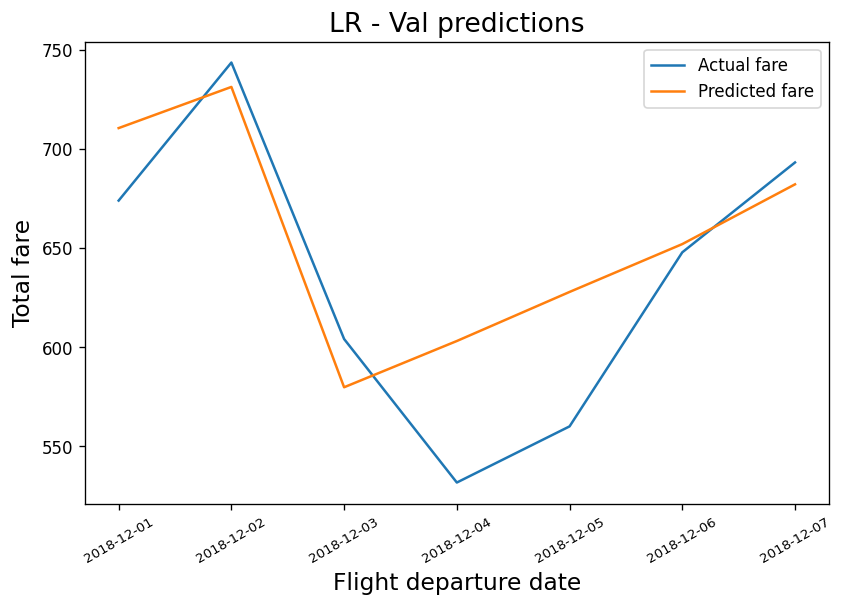

In [30]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('total_fare').mean()), 
    x = "flt_departure_dt", 
    y = "total_fare",
    label = "Actual fare"
)

sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('pred_fare').mean()), 
    x = "flt_departure_dt", 
    y = "pred_fare",
    label = "Predicted fare"
)

locs, labels = plt.xticks()
plt.xticks(
    locs,
    [l.get_text() for l in labels],
    rotation = 30,
    fontsize = 8
)

plt.legend()
plt.title("LR - Val predictions", fontsize = 16)
plt.xlabel("Flight departure date", fontsize = 14)
plt.ylabel("Total fare", fontsize = 14)
plt.show()

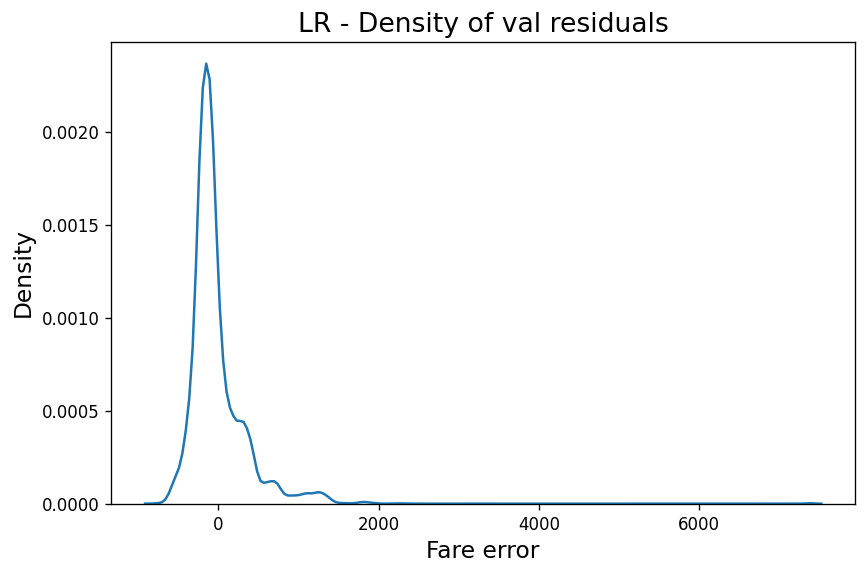

In [31]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.kdeplot(
    val_df['total_fare'] - val_df['pred_fare']
)
plt.title("LR - Density of val residuals", fontsize = 16)
plt.xlabel("Fare error", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.show()

### Metrics

In [32]:
print_metrics(
    train_df['total_fare'], train_df['pred_fare'],
    label = 'Train - LR'
)

print_metrics(
    val_df['total_fare'], val_df['pred_fare'],
    label = 'Val - LR'
)

Train - LR
RMSE: 386.3524
MAE: 233.3139
R2: 31.279%
Max error: 5585.8844

Val - LR
RMSE: 355.5501
MAE: 238.8155
R2: 30.647%
Max error: 7386.1316



### Feature importances

In [33]:
pl.DataFrame({
    "Feature": best_model['ridge'].feature_names_in_,
    "Coef": best_model['ridge'].coef_
}).sort("Coef")

Feature,Coef
str,f64
"""ohe__destination_id_1""",-0.042399
"""ohe__destination_id_2""",-0.036235
"""scaler__days_till_flight""",-0.02316
"""ohe__destination_id_5""",-0.016601
"""ohe__destination_id_6""",-0.014897
"""ohe__origin_id_3""",-0.003672
"""scaler__flt_departure_week""",-0.003317
"""scaler__days_since_start""",-0.003059
"""ohe__carrier_U1""",-0.002086
